In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle

import numpy as np
from astropy.cosmology import Planck18
import astropy.units as u
import astropy.constants as c
from scipy import interpolate, integrate

import py21cmfast as p21c

import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append(os.environ['DH_DIR'])
from darkhistory.config import load_data

sys.path.append(os.environ['DM21CM_DIR'])

import dm21cm.physics as phys
from dm21cm.evolve import evolve
from dm21cm.injections.pbh import PBHInjection
from dm21cm.injections.zero import ZeroInjection
from dm21cm.utils import abscs
from dm21cm.dh_wrapper import DarkHistoryWrapper

from preprocessing.step_size import pbh_f

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


## General

In [ ]:
1.25 / (1.5*c.k_B).to('eV/K')

<Quantity 9670.43176796 K / eV>

## 1. DH runs comparison

In [ ]:
pbh_f(10**13.2)

2.511886431509613e-10

In [ ]:
dh_injection = PBHInjection(
    m_PBH = 10**13.2,
    f_PBH = 200*pbh_f(10**13.2),
)
dh_injection.set_binning(abscs)
dh = DarkHistoryWrapper(dh_injection, prefix=p21c.config[f'direc'])
sol = dh.evolve(end_rs=500, rerun=True)
pickle.dump(sol, open(f"sol200_c1.p", "wb"))

In [2]:
sol_0 = pickle.load(open("sol0.p", 'rb'))
sol_1 = pickle.load(open("sol1.p", 'rb'))
sol_2 = pickle.load(open("sol2.p", 'rb'))
sol_200 = pickle.load(open("sol200.p", 'rb'))
sol_200c = pickle.load(open("sol200_c1.p", 'rb'))
sol_20000 = pickle.load(open("sol20000.p", 'rb'))

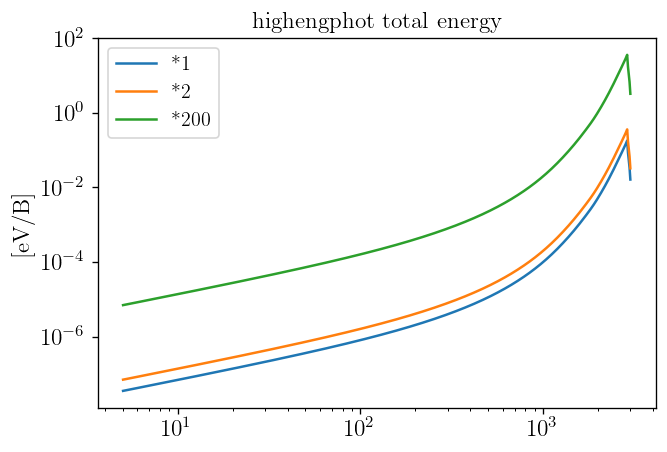

In [59]:
spec_1 = sol_1['highengphot']
spec_1.switch_spec_type('N')
spec_2 = sol_2['highengphot']
spec_2.switch_spec_type('N')
spec_200 = sol_200['highengphot']
spec_200.switch_spec_type('N')
plt.plot(sol_1['rs'], [np.dot(spec_1.eng, n) for n in spec_1.grid_vals], label='*1')
plt.plot(sol_2['rs'], [np.dot(spec_2.eng, n) for n in spec_2.grid_vals], label='*2')
plt.plot(sol_200['rs'], [np.dot(spec_200.eng, n) for n in spec_200.grid_vals], label='*200')
plt.ylabel('[eV/B]');
plt.yscale('log')
plt.xscale('log')
plt.title('highengphot total energy')
plt.legend()

/tmp/ipykernel_1562163/3019187316.py:61: RuntimeWarning: divide by zero encountered in divide
  rdr_dict[key] = rd_dict[key] / rd_dict['1']
/tmp/ipykernel_1562163/3019187316.py:61: RuntimeWarning: invalid value encountered in divide
  rdr_dict[key] = rd_dict[key] / rd_dict['1']


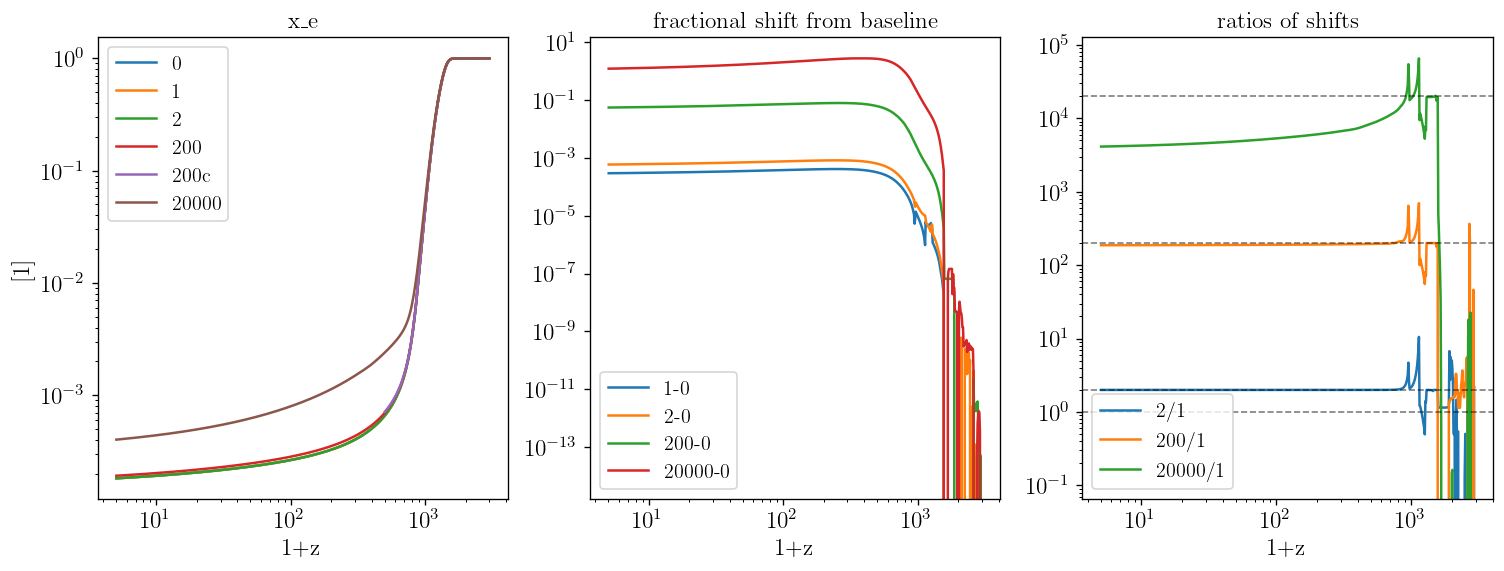

In [65]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sol_dict = {
    '0': pickle.load(open("sol0.p", 'rb')),
    '1': pickle.load(open("sol1.p", 'rb')),
    '2': pickle.load(open("sol2.p", 'rb')),
    '200': pickle.load(open("sol200.p", 'rb')),
    '200c': pickle.load(open("sol200_c1.p", 'rb')),
    '20000': pickle.load(open("sol20000.p", 'rb')),
}

plot_type = 'x_e'

ax = axs[0]
for key, sol in sol_dict.items():
    if plot_type == 'Tk':
        ax.plot(sol['rs'], sol['Tm'] / phys.kB, label=key)
        plot_unit = '[K]'
    elif plot_type == 'x_e':
        ax.plot(sol['rs'], sol['x'][:,0], label=key)
        plot_unit = '[1]'
ax.set(xscale='log', yscale='log', ylabel=plot_unit, xlabel='1+z', title=plot_type)
ax.legend()

if plot_type == 'Tk':
    rd_dict = {}
    for key, sol in sol_dict.items():
        if key == '0':
            continue
        if key == '200c':
            sol_0_for_200c = interpolate.interp1d(sol_0['rs'], sol_0['Tm'])(sol_200c['rs'])
            rd_dict[key] = (sol['Tm'] - sol_0_for_200c)/sol_0_for_200c
        else:
            rd_dict[key] = (sol['Tm'] - sol_0['Tm'])/(sol_0['Tm'])
elif plot_type == 'x_e':
    rd_dict = {}
    for key, sol in sol_dict.items():
        if key in ['0', '200c']:
            continue
        rd_dict[key] = (sol['x'][:,0] - sol_0['x'][:,0])/(sol_0['x'][:,0])

ax = axs[1]
for key, rd in rd_dict.items():
    ax.plot(sol_dict[key]['rs'], rd, label=key+'-0')
ax.set(xscale='log', yscale='log', title='fractional shift from baseline', xlabel='1+z')
ax.legend()

if plot_type == 'Tk':
    rdr_dict = {}
    for key, sol in sol_dict.items():
        if key in ['0', '1', '200c']:
            continue
        rdr_dict[key] = rd_dict[key] / rd_dict['1']
    rd1_for_200c = interpolate.interp1d(sol_1['rs'], rd_dict['1'])(sol_200c['rs'])
    rdr_dict['200c'] = rd_dict['200c'] / rd1_for_200c
elif plot_type == 'x_e':
    rdr_dict = {}
    for key, sol in sol_dict.items():
        if key in ['0', '1', '200c']:
            continue
        rdr_dict[key] = rd_dict[key] / rd_dict['1']

ax = axs[2]
for key, rdr in rdr_dict.items():
    ax.plot(sol_dict[key]['rs'], rdr, label=key+'/1')
ax.set(xscale='log', yscale='log', title='ratios of shifts', xlabel='1+z')
ax.axhline(1, color='k', ls='--', lw=1, alpha=0.5)
ax.axhline(2, color='k', ls='--', lw=1, alpha=0.5)
ax.axhline(200, color='k', ls='--', lw=1, alpha=0.5)
ax.axhline(20000, color='k', ls='--', lw=1, alpha=0.5)
ax.legend();

## 2. DH: photon survival rate

In [42]:
dh_injection = PBHInjection(
    m_PBH = 10**13.2,
    f_PBH = 200*pbh_f(10**13.2),
)
dh_injection.set_binning(abscs)

In [43]:
import dm21cm.physics as phys
phys.n_B

2.5175081792028336e-07

In [35]:
print(dh_injection.inj_power(z=2873) / phys.n_B, 'eV / B s')
print(dh_injection.inj_power(z=2872) / phys.n_B, 'eV / B s')
(Planck18.age(2873) - Planck18.age(3000)).to('s')

71.87693486831913 eV / B s
3.9721817321628283e-94 eV / B s


/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


<Quantity 1.63001265e+11 s>

In [67]:
e, _ = integrate.quad(lambda z: phys.dtdz(1+z) * dh_injection.inj_power(z=z) / (phys.n_B*(1+z)**3), 3000, 2873)
print(f'{e:.3e} eV / B')

3.802e+01 eV / B


/tmp/ipykernel_1562163/3813330191.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  e, _ = integrate.quad(lambda z: phys.dtdz(1+z) * dh_injection.inj_power(z=z) / (phys.n_B*(1+z)**3), 3000, 2873)


In [70]:
np.log10(hep_tf.eng[-1]), hep_tf.eng[-1]

(12.728793934188179, 5355424908402.668)

In [ ]:
dir(dh_injection)

In [ ]:
load_data?

In [44]:
load_data('dep_tf').keys()

[2024-05-08 14:36:16,522] INFO: darkhistory.config: Loaded deposition transfer functions.


dict_keys(['highengphot', 'lowengphot', 'lowengelec', 'highengdep', 'CMB_engloss'])

In [46]:
hep_tf = load_data('dep_tf')['highengphot']

[2024-05-08 14:37:37,020] INFO: darkhistory.config: Loaded deposition transfer functions.


In [ ]:
rs = 2873
dlnz = hep_tf.dlnz[-1]
coarsen_factor = 1
print(dlnz, coarsen_factor)
tf = hep_tf.get_tf(0.5, 0.5, rs)
assert tf.spec_type == 'N'
tot_tf = tf.grid_vals

while rs > 900:
    rs = np.exp(np.log(rs) - dlnz * coarsen_factor)
    print(rs)
    tf = hep_tf.get_tf(0.5, 0.5, rs)
    assert tf.spec_type == 'N'
    tot_tf = tf.grid_vals @ tot_tf

In [82]:
hep_tf.get_tf(0.5, 0.5, 3000).grid_vals.shape

(500, 500)

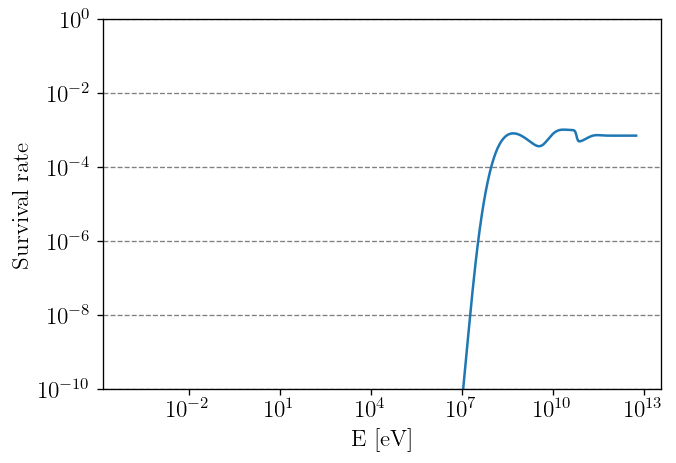

In [78]:
fig, ax = plt.subplots()
ax.plot(hep_tf.eng, (tot_tf @ hep_tf.eng / hep_tf.eng))
ax.set(xscale='log', yscale='log', xlabel='E [eV]', ylabel='Survival rate')
ax.set(ylim=(1e-10, 1e0))
ax.yaxis.grid(color='gray', linestyle='dashed')